In [3]:
import matplotlib.pyplot as plt 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
from pandas import datetime
from random import random
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.ar_model import AR
import warnings
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings('ignore')
data = pd.read_csv('/Users/alket/Desktop/dati/new_data_backfill_forwfill.csv',index_col = 0)

gbc = data.groupby(by = data['cell_num'])
cell_1 = gbc.get_group('486-1258')
cell_2 = gbc.get_group('498-1268')
series1 = cell_1['nr_people'].tolist()

from statsmodels.compat.pandas import deprecate_kwarg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
# additive decompose a contrived additive time series
from random import randrange
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose 

# the main library has a small set of functionality
from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import (naive,
                                         drift, 
                                         mean, 
                                         seasonal_naive)
%load_ext autoreload
%autoreload 2



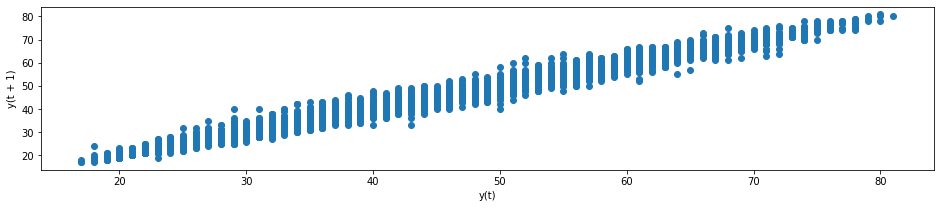

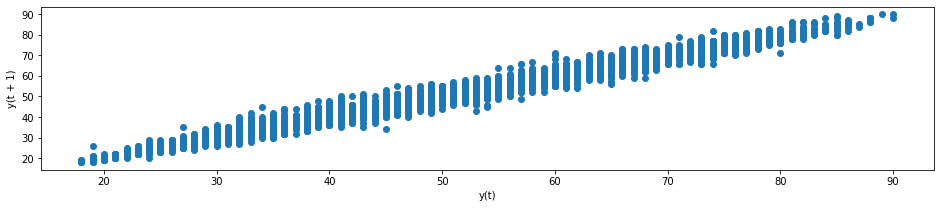

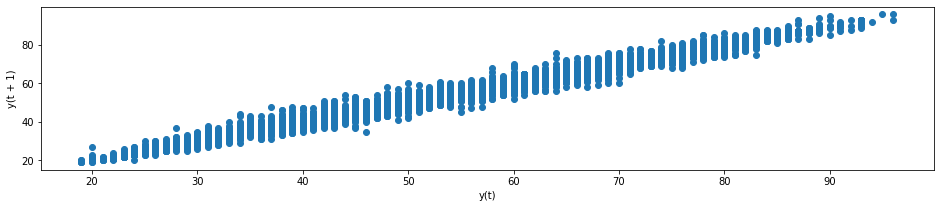

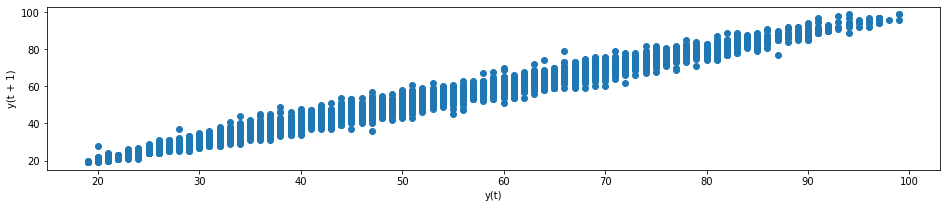

In [5]:
count = 0
for i, k in gbc:
    plt.figure(figsize=(16,3))
    lag_plot(k['nr_people'])
    plt.show();
    count += 1
    if count > 3: break

### Autocorrelation

<p>Because the correlation is calculated between the variable and itself at previous time steps,
it is called an autocorrelation.
We can use statistical measures to calculate the correlation between the output variable and values at
previous time steps at various different lags. The stronger the correlation between the output variable and
a specific lagged variable, the more weight that autoregression model can put on that variable when modeling. 
It is also called serial correlation because of the sequenced structure of time series data. The correlation 
statistics can also help to choose which lag variables will be useful in a model and which will not. Interestingly,
if all lag variables show low or no correlation with the output variable, then it suggests that 
the time series problem may not be predictable. This can be very useful when getting started on a new dataset.
</p>

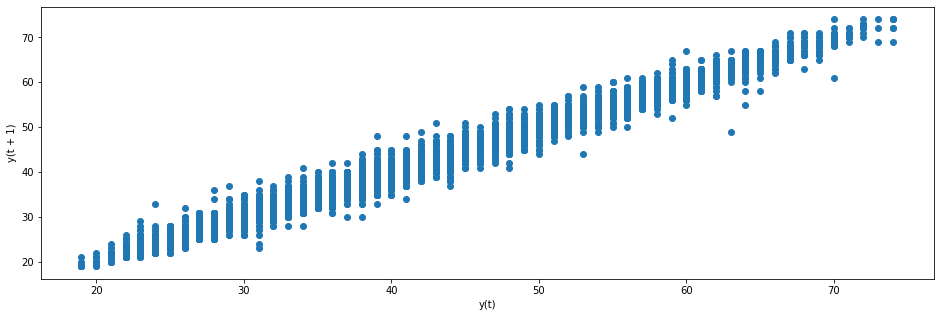

In [6]:
plt.figure(figsize=(16,5))
lag_plot(cell_1['nr_people'])
plt.show();

<p>
We can plot the correlation coefficient for each lag variable. This can very quickly give an idea of which lag variables may be good candidates for use in a predictive model and how the relationship between the observation and its historic values changes over time. 
</p>

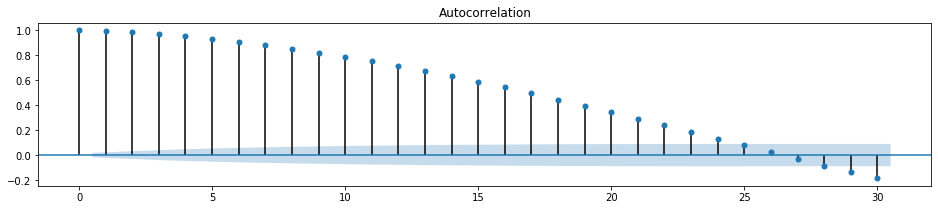

In [7]:
values = pd.DataFrame(cell_1['nr_people'])

with plt.rc_context():
     plt.rc("figure", figsize=(16,3))
     plot_acf(values, lags=30);

### Autoregression model

<p>The Statsmodels library provides an autoregression model that automatically selects an appropriate lag value 
using statistical tests and trains a linear regression model. It is provided in the AR class 
</p>

In [ ]:
dict2data = {}
dict2MAPE = {}
for i, k in gbc:
# split dataset
    cell = i
    df = pd.DataFrame(k['nr_people'])
    X= df.values
    print('Cell ',i)

    train, test = X[:len(X)-2808], X[len(X)-2808:]
    print(len(train), len(test))
    # train autoregression
    model = AR(train)
    model_fit = model.fit()
    window = model_fit.k_ar
    print(window)
    coef = model_fit.params

    # walk forward over time steps in test
    history = train[len(train)-window:]
    history = [history[i] for i in range(len(history))]

    predictions = list()

    for t in range(len(test)):
        length = len(history)
        lag = [history[i] for i in range(length-window,length)]
        yhat = coef[0]
        for d in range(window):
            yhat += coef[d+1] * lag[window-d-1]
        obs = test[t]
        predictions.append(yhat)
        history.append(obs)
        #print('predicted=%f, expected=%f' % (yhat, obs))
    
    predictions = np.asarray(predictions)
    history = np.asarray(test)
    
    plt.figure(figsize = (15, 3))
    plt.plot(history[:490], color = 'black', label = 'expected')
    plt.plot(predictions[:490], color = 'gray', label = 'predicted')
    plt.legend();
    plt.show()
    
    difference = abs(predictions - history)
    MAPE = np.mean(abs(100 * (difference/history)))
    dict2MAPE[cell] = MAPE
    plt.figure(figsize=(16, 1))
    plt.boxplot(difference, vert = False);
    plt.show()  
    # collect data 2 dictionary
    minimum = np.amin(difference)   
    per75 = np.percentile(difference, 75)
    per50 = np.percentile(difference, 50)
    per25 = np.percentile(difference, 25)
    maximum = np.amax(difference)
    l5i = [minimum, per25, per50, per75, maximum]
    dict2data[cell] = l5i

### Scrivi dati errore di previsione per Autoregression

In [ ]:
with open('error_data_4_Autoregression_37_StepForecast.csv', 'w') as f:
    for key, value in dict2data.items():
        f.write('%s:%s\n' % (key, value))

In [ ]:
with open('MAPE_data_4_Autoregression_37_StepForecast.csv', 'w') as f:
    for key, value in dict2MAPE.items():
        f.write('%s:%s\n' % (key, value))

### Calcolo per tutte le celle con STL decomposition

In [10]:
def get_AR_prediction(X):   
    
    train, test = X[:len(X)-2808], X[len(X)-2808:]
    #print(len(train), len(test))
    # train autoregression
    model = AR(train)
    model_fit = model.fit()
    window = model_fit.k_ar
    window = 24
    print(window)
    coef = model_fit.params

    # walk forward over time steps in test
    history = train[len(train)-window:]
    history = [history[i] for i in range(len(history))]

    predictions = list()

    for t in range(len(test)):
        length = len(history)
        lag = [history[i] for i in range(length-window,length)]
        yhat = coef[0]
        for d in range(window):
            yhat += coef[d+1] * lag[window-d-1]
        obs = test[t]
        predictions.append(yhat)
        history.append(obs)
        #print('predicted=%f, expected=%f' % (yhat, obs))
    
    predictions = np.asarray(predictions)
    
    return predictions

In [11]:
dict2data = {}
dict2MAPE = {}
dict2RMSE = {}
counter = 0
for i, k in gbc:

    cell = i
    error_list = []
    print(counter)
    counter +=1
    #if counter > 17: break
    dates4dec = []
    cell_values = []

    for index, row in k.iterrows():
    
        date = row['date']
        h = str(row['hours'])
   
        h = h.split('.')
    
        if len(h[0])<2:
            h = h[1]+h[0]
        else: 
            h = h[0]
   
        minutes = str(row['minutes'])
        m = ''
        minutes = minutes.split('.')
        if len(minutes[0]) < 2: 
            m = minutes[0] +'0'
        else: 
            m = minutes[0]
        #print(date, h, m)
        data_f = date+' '+h+':'+m+':'+'00'
        #print(data_f)
        cell_values.append(row['nr_people'])
        dates4dec.append(data_f) 


    dict_i = {'ds': dates4dec, 'y':cell_values}
    data4deco = pd.DataFrame(dict_i, index=None, columns=None)  
    data4deco.head()

    data4deco['ds'] = pd.to_datetime(data4deco['ds'])
    data4deco = data4deco.set_index('ds')
    data4deco.head()


    # decomponi i dati in trend, residual e seasonal
    decomp = decompose(data4deco['y'], period=96)
    
    trend = decomp.trend.values
    seasonal = decomp.seasonal.values
    residual = decomp.resid.values
    
    predicted_trend = get_AR_prediction(trend)
    predicted_seasonal = get_AR_prediction(seasonal)
    predicted_residual = get_AR_prediction(residual)
    
    final_predictions = predicted_trend + predicted_seasonal + predicted_residual
    
    train_test_size = 9000
    dataset = k
    X, y = dataset[:train_test_size], dataset[train_test_size:]
    test_X, test_y = X['nr_people'].values, y['nr_people'].values
     # prepare train-test della serie originale
    
    expected = test_y
    difference = abs(final_predictions - test_y)
    
    pow_err = np.power(difference, 2)
    rmse = math.sqrt(np.mean(pow_err))
    
    MAPE = np.mean(abs(100 * (difference/test_y)))
    dict2MAPE[cell] = MAPE
    print('MAPE', MAPE)
    #plt.figure(figsize=(16, 1))
    #plt.boxplot(difference, vert = False);
    #plt.show()  
    # collect data 2 dictionary
    minimum = np.amin(difference)   
    per75 = np.percentile(difference, 75)
    per50 = np.percentile(difference, 50)
    per25 = np.percentile(difference, 25)
    maximum = np.amax(difference)
    l5i = [minimum, per25, per50, per75, maximum]
    dict2data[cell] = l5i
    dict2MAPE[cell] = MAPE
    
with open('error_data_4_Autoregression_with_STL_Decom__37_StepForecast.csv', 'w') as f:
    for key, value in dict2data.items():
        f.write('%s:%s\n' % (key, value))    
        
with open('MAPE_data_4_Autoregression_37_StepForecast.csv', 'w') as f:
    for key, value in dict2MAPE.items():
        f.write('%s:%s\n' % (key, value))        

0
24
24
24
MAPE 2.9587571309353704
1
24
24
24
MAPE 4.230549305757374
2
24
24
24
MAPE 3.3726716144533797
3
24
24
24
MAPE 5.494899682952638
4
24
24
24
MAPE 4.028298068896018
5
24
24
24
MAPE 5.625283309683034
6
24
24
24
MAPE 6.093514549125011
7
24
24
24
MAPE 2.264418349037995
8
24
24
24
MAPE 6.783455544962198
9
24
24
24
MAPE 2.3152724650019803
10


KeyboardInterrupt: 